In [1]:
import time
import warnings
import numpy as np
np.set_printoptions(suppress=True)
import torch
import rasterio
import cv2
import cv2 as cv
import os
import os.path as osp
import joblib
import argparse
import open_earth_map.oem as oem
from oem.dataset import load_multiband
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import scipy.stats

import torchvision
from torchvision import transforms
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torchmetrics import JaccardIndex, Dice

import torch_geometric.transforms as T
import torch_geometric
from torch_geometric.nn import GCNConv, GeneralConv
from torch_geometric.logging import init_wandb, log
from torch_geometric.data import InMemoryDataset, Data

from typing import Callable, List, Optional
import wandb
wandb.login()

from dai_torch import *
from dai import *

root = 'graph_data'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Path to the OpenEarthMap directory
OEM_DATA_DIR = "OpenEarthMap_Mini/"

# Training and validation file list
TRAIN_LIST = os.path.join(OEM_DATA_DIR, "train.txt")
VAL_LIST = os.path.join(OEM_DATA_DIR, "val.txt")
TEST_LIST = os.path.join(OEM_DATA_DIR, "test.txt")

IMG_SIZE = 512
N_CLASSES = 9
LR = 0.0001
BATCH_SIZE = 4
NUM_EPOCHS = 10
DEVICE = "cuda"
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

raw_dir = os.path.join(root, 'raw')

fns = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "images" in str(f)]
train_fns = [str(f) for f in fns if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in fns if f.name in np.loadtxt(VAL_LIST, dtype=str)]
test_fns = [str(f) for f in fns if f.name in np.loadtxt(TEST_LIST, dtype=str)]

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("Total samples      :", len(fns))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))
print("Test samples:", len(test_fns))

shnet = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x0_5', pretrained=True)
modules=list(shnet.children())[:-1]
shnet=nn.Sequential(*modules)
shnet.to(device)
shnet.eval()

train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
)
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES)

wandb: Currently logged in as: daidew. Use `wandb login --relogin` to force relogin


cuda
Total samples      : 1068
Training samples   : 663
Validation samples : 92
Test samples: 313


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0


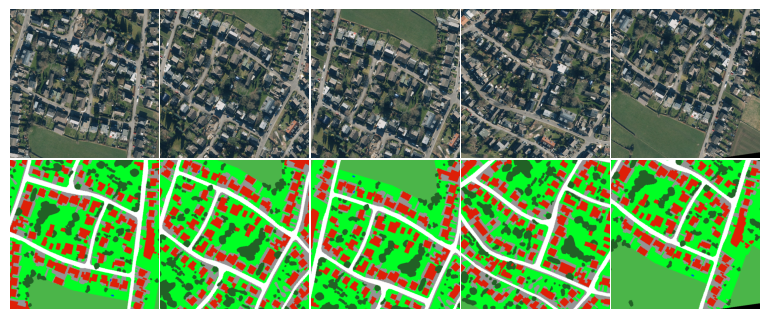

In [2]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 1
for i in range(5):
    img, msk, fn = train_data[IDX]

    img = np.moveaxis(img.numpy(), 0, -1)
    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")

plt.show()

# Generate raw graph dataset

In [ ]:
shnet = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x0_5', pretrained=True)
modules=list(shnet.children())[:-1]
shnet=nn.Sequential(*modules)
shnet.to(device)
shnet.eval()


for chosen_idx in tqdm(range(len(train_data))):
# for chosen_idx in tqdm(range(5)):
# chosen_idx = 0
# chosen_idx = np.random.randint(len(train_data))

    img, msk, fn = train_data[chosen_idx]

    img = np.moveaxis(img.numpy(), 0, -1)
    msk_discrete = np.argmax(msk.numpy(), axis=0)

    img_small_size = (256, 256)
    img_small = cv2.resize(img, dsize=img_small_size, interpolation=cv2.INTER_CUBIC)
    msk_discrete_small = cv2.resize(msk_discrete, dsize=img_small_size, interpolation=cv2.INTER_NEAREST)

    dst_small = cv2.Canny(np.uint8(img_small*255), 50, 200, None, 3)
    dst_small = dst_small>0

    thresh, cnt_area_max = 0.03, 15
    partition_res_small, mean_c_res_small, res_lst_small, cnt_res_lst_small, num_nodes_small = partition_image(dst_small, img_small, thresh=thresh, cnt_area_max=cnt_area_max)

    print('partition_res_small.shape:',partition_res_small.shape, 
          'mean_c_res_small.shape:', mean_c_res_small.shape, 
          'len(cnt_res_lst_small):', len(cnt_res_lst_small), 
          'len(res_lst_small):', len(res_lst_small),
          'num_nodes_small:', num_nodes_small)

    partition_res = cv2.resize(partition_res_small, dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    
    r, s_lst, p_lst = avg_acc(num_nodes_small, partition_res, res_lst_small, msk_discrete)
    
    V,E = generate_graph_from_partition(partition_res_small)
    print('num nodes:', len(V), 'num edges:', np.sum([len(E[t]) for t in E.keys()]) / 2)
    print(f'cnt_area_max: {cnt_area_max}, r: {r}, num_nodes:{num_nodes_small}')
    
    crop_img_dataset_small = CroppedImageDataset(fn, img_small, partition_res_small, res_lst_small, num_nodes_small, preprocess)
    dataloader = DataLoader(crop_img_dataset_small, batch_size=512, shuffle=False)
    torch.cuda.empty_cache()
    ts_lst = []
    for ts in dataloader:
        with torch.no_grad():
            val = shnet(ts.to(device))
            ts_lst.append(val.detach().cpu())
    with torch.no_grad():
        feats = torch.mean(torch.cat(ts_lst, axis=0),axis=(-2,-1)).detach().cpu().numpy()
    
#     x = mean_c_res # use mean color pixels as the feature for now.
    x = feats
    y = generate_labels_from_graph(res_lst_small, msk_discrete_small, num_nodes_small)

    etc = {'partition_res': partition_res,
           'partition_res_small': partition_res_small,
           'mean_c_res':mean_c_res_small, 
           'res_lst_small':res_lst_small, 
           'cnt_res_lst_small':cnt_res_lst_small,
           'num_nodes_small':num_nodes_small, 
           'r': r, 
           's_lst': s_lst, 
           'p_lst': p_lst, 
           'thresh': thresh,
           'cnt_area_max':cnt_area_max,
           'msk_discrete': msk_discrete,
           'msk_discrete_small':msk_discrete_small,
           'dst_small': dst_small
          }
    
    root = 'graph_data'
    g_filename = 'ind.'+'-'.join(fn.split(os.sep))
    x_filename = 'feat.'+'-'.join(fn.split(os.sep))
    y_filename = 'label.'+'-'.join(fn.split(os.sep))
    g_filepath = os.path.join(root, 'raw', g_filename)
    x_filepath = os.path.join(root, 'raw', x_filename)
    y_filepath = os.path.join(root, 'raw', y_filename)
    etc_filepath = os.path.join(root, 'etc', 'etc.'+'-'.join(fn.split(os.sep)))
    print(f'saving to {g_filepath}, {x_filepath}, {etc_filepath}, {y_filepath}..')

    with open(g_filepath, 'w') as f2:
        for t in sorted(E.keys()):
            f2.write(str(t)+';'+';'.join([str(x) for x in E[t]])+'\n')
    with open(x_filepath, 'wb') as f2:
        np.save(f2, x, allow_pickle=True, fix_imports=True)
    with open(y_filepath, 'wb') as f2:
        np.save(f2, y, allow_pickle=True, fix_imports=True)
    with open(etc_filepath, 'wb') as f2:
        joblib.dump(etc, f2)

In [2]:
class GATv2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc_lst = nn.ModuleList([nn.Linear(1024, 512), nn.Linear(512, 256), nn.Linear(256, 128)])
        
        self.conv_lst = nn.ModuleList([GATv2Conv(128, 128, heads=2, concat=False) for _ in range(5)])
        
        self.fc_lst2 = nn.ModuleList([nn.Linear(128, 9)])

        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for fc in self.fc_lst:
            x = F.relu(fc(x))
        
        for gc in self.conv_lst:
            x = F.relu(gc(x, edge_index)) + x

        for fc in self.fc_lst2:
            x = fc(F.relu(x))
            
        return F.log_softmax(x, dim=1)
    
class GATv2Tiny(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc_lst = nn.ModuleList([nn.Linear(1024, 9)])
        
        self.conv_lst = nn.ModuleList([GATv2Conv(9, 9, heads=1, concat=False) for _ in range(1)])
        
        self.fc_lst2 = nn.ModuleList([nn.Linear(9, 9)])

        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for fc in self.fc_lst:
            x = F.relu(fc(x))
        
        for gc in self.conv_lst:
            x = F.relu(gc(x, edge_index))

        for fc in self.fc_lst2:
            x = fc(F.relu(x))
            
        return F.log_softmax(x, dim=1)
    
model = GATv2()
model

GATv2(
  (fc_lst): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (conv_lst): ModuleList(
    (0): GATv2Conv(128, 128, heads=2)
    (1): GATv2Conv(128, 128, heads=2)
    (2): GATv2Conv(128, 128, heads=2)
    (3): GATv2Conv(128, 128, heads=2)
    (4): GATv2Conv(128, 128, heads=2)
  )
  (fc_lst2): ModuleList(
    (0): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [16]:
train_dataset = SegGraphDataset(root, transform=transforms.Compose([]), load_etc=True, custom_fns=train_fns)
val_dataset = SegGraphDataset(root, transform=transforms.Compose([]), load_etc=True, custom_fns=val_fns, custom_data=(train_dataset.data, train_dataset.slices))
len(val_dataset), len(train_dataset)

included data: 658
loading 658 etc files..


  0%|          | 0/658 [00:00<?, ?it/s]

included data: 92
loading 92 etc files..


  0%|          | 0/92 [00:00<?, ?it/s]

(92, 658)

In [17]:
def dice_loss(y_maps_small, target, device, num_classes=9, eps=1e-5):
    p = F.softmax(y_maps_small, dim=-1)
    g = F.one_hot(target, num_classes=num_classes)
    eps = torch.tensor(eps).to(device)
    pg = (p * g).sum((0, 1, 2)) + eps
    p2q2 = (p*p).sum((0, 1, 2)) + (g).sum((0, 1, 2)) + eps
    d = 2 * pg / p2q2
    return -torch.clip(d, min=0, max=1)

def generate_y_maps_from_node_pred(pred, res_lst_small, y_maps_shape, num_nodes_small, device):
    y_maps_small = torch.zeros(y_maps_shape, dtype=pred.dtype).to(device)
    for i in range(num_nodes_small):
        index = torch.tensor(res_lst_small[i], dtype=int).to(device).T
        y_maps_small[index] = pred[i]
        
    y_maps_small = torch.transpose(y_maps_small, -1, 0).unsqueeze(0)

    return y_maps_small

def img_data_to_graph_data(img_dataset, chosen_idx, model_feats, device, preprocess,
                    thresh=0.03, cnt_area_max=15, img_small_size=(256, 256)):
    with torch.no_grad():
        img, msk, fn = img_dataset[chosen_idx]
        prd_size = img.shape[1:]
        img = np.moveaxis(img.numpy(), 0, -1)
        msk_discrete = np.argmax(msk.numpy(), axis=0)
        msk_discrete = cv2.resize(msk_discrete, dsize=prd_size, interpolation=cv2.INTER_NEAREST)
        msk_discrete_rgb = oem.utils.make_rgb(msk_discrete)

        img_small = cv2.resize(img, dsize=img_small_size, interpolation=cv2.INTER_CUBIC)
        msk_discrete_small = cv2.resize(msk_discrete, dsize=img_small_size, interpolation=cv2.INTER_NEAREST)

        dst_small = cv2.Canny(np.uint8(img_small*255), 50, 200, None, 3)
        dst_small = dst_small>0

        partition_res_small, mean_c_res_small, res_lst_small, cnt_res_lst_small, num_nodes_small = partition_image(dst_small, img_small, thresh=thresh, cnt_area_max=cnt_area_max)

        partition_res = cv2.resize(partition_res_small, dsize=prd_size, interpolation=cv2.INTER_NEAREST)

        r, s_lst, p_lst = avg_acc(num_nodes_small, partition_res, res_lst_small, msk_discrete)

        V,E = generate_graph_from_partition(partition_res_small)

        crop_img_dataset_small = CroppedImageDataset(fn, img_small, partition_res_small, res_lst_small, num_nodes_small, preprocess)
        dataloader = DataLoader(crop_img_dataset_small, batch_size=128, shuffle=False)
        
        
        ts_lst = []
        for ts in dataloader:
            val = model_feats(ts.to(device))
            ts_lst.append(val.detach().cpu())
            del ts
            torch.cuda.empty_cache()

        del crop_img_dataset_small, dataloader
        feats = torch.mean(torch.cat(ts_lst, axis=0),axis=(-2,-1)).detach().cpu()

    #     x = mean_c_res # use mean color pixels as the feature for now.
        x = feats
        y = torch.tensor(generate_labels_from_graph(res_lst_small, msk_discrete_small, num_nodes_small), dtype=torch.long)


        edge_index = [[int(u), int(v)] for u in E.keys() for v in E[u]]
        edge_index = torch.tensor(edge_index).T 

        data = Data(x=x, edge_index=edge_index, y=y)

        _log = {}
        _log['prd_size'] = prd_size
        _log['img'] = img
        _log['msk'] = msk
        _log['fn'] = fn
        _log['msk_discrete'] = msk_discrete
        _log['msk_discrete_rgb'] = msk_discrete_rgb
        _log['img_small'] = img_small
        _log['msk_discrete_small'] = msk_discrete_small
        _log['dst_small'] = dst_small

        _log['partition_res'] = partition_res
        _log['partition_res_small'] = partition_res_small
        _log['mean_c_res_small'] = mean_c_res_small
        _log['res_lst_small'] = res_lst_small
        _log['cnt_res_lst_small'] = cnt_res_lst_small
        _log['num_nodes_small'] = num_nodes_small
        _log['r'] = r
        _log['x'] = x
        _log['y'] = y
        _log['V'] = V
        _log['E'] = E
        _log['edge_index'] = edge_index
    
    return data, _log

class FocalLoss(nn.Module):
    "Focal loss implemented using F.cross_entropy"
    def __init__(self, gamma: float = 2.0, weight=None, reduction: str = 'mean') -> None:
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction


    def forward(self, inp: torch.Tensor, targ: torch.Tensor):
        ce_loss = F.cross_entropy(inp, targ, weight=self.weight, reduction="none")
        p_t = torch.exp(-ce_loss)
        loss = (1 - p_t)**self.gamma * ce_loss
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss
    
@torch.no_grad()
def get_w(msk_discrete_small, num_classes=9, ignore_index=None):
    y_appear, y_appear_cnt = np.unique(msk_discrete_small, return_counts=True)
    w = np.zeros(num_classes)
    w[y_appear] = y_appear_cnt
#     w[ignore_index] = 0
    w[y_appear] = np.sum(y_appear_cnt) - w[y_appear]
#     w[ignore_index] = 0
    return w


def _custom_loss(out, data, target, target_one_hot, y_maps_small, _gamma1, _gamma2, _alpha, _beta, w):
    _pixel_nll_loss = F.nll_loss(y_maps_small.contiguous(), target, ignore_index=0, weight=w)
    _pixel_jac_loss = criterion(y_maps_small.contiguous(), target_one_hot)

    
    _node_nll_loss = F.nll_loss(out, data.y, weight=w)
    _node_foc_loss = focal_loss(out, data.y)

    _loss = _gamma1*_pixel_nll_loss + _gamma2*_pixel_jac_loss + _alpha*_node_nll_loss + _beta*_node_foc_loss
    
    return _loss, _pixel_nll_loss, _pixel_jac_loss, _node_nll_loss, _node_foc_loss

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GCN().to(device).float()
# model = GeneralGCN().to(device).float()
# model = GATv2().to(device).float()
# model = GATv2Tiny().to(device).float()
lr = 0.01
# model = torch.load(osp.join('saved_models', f'model_latest.pt')).to(device).float()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)
# optimizer.load_state_dict(torch.load(osp.join('saved_models', f'optim_latest.pt')).state_dict())

jaccard = JaccardIndex(task="multiclass", num_classes=9, average='macro').to(device)
criterion = oem.losses.JaccardLoss()
foc_gamma = 2.0
focal_loss = FocalLoss(gamma=foc_gamma).to(device)
_gamma1, _gamma2, _alpha, _beta = 0.1, 0.05, 0.2, 0.2
batch_size = 4
K = 16
model.train()
N = len(train_dataset)
N_val = len(val_dataset)
os.makedirs('saved_models', exist_ok=True)
os.makedirs('analysis', exist_ok=True)
pbar = tqdm(range(100000000000))
load_etc = False
eval_epoch = 1
model_save_epoch = 1
# model_save_epoch = 10000000000000000000000
update_per_epoch = 15

optimizer.zero_grad()
torch.cuda.empty_cache()

analysis = {'graph_analysis': []}
dataset_temp = [None for _ in range(N)]


w = torch.tensor([0, 5.2, 2.48 , 2.82, 3.70,2.60, 4.42, 2.98, 2.86]).float().to(device)

_config = {'lr': lr, 'foc_gamma': foc_gamma, '_gamma1': _gamma1, '_gamma2': _gamma2, '_alpha': _alpha, '_beta': _beta, 'batch_size': batch_size, 'K': K, 'eval_epoch': eval_epoch, 'model_save_epoch': model_save_epoch, 'update_per_epoch': update_per_epoch}
          
# wandb.init(project='remote-sensing', reinit=True, config = _config)



for epoch in pbar:
    idxs = np.random.randint(0, N, size=batch_size*K)
    print(f'----- epoch {epoch} -----')
    print('chosen idxs:', idxs)

    # load partition_res_lst
    datas, _logs = [], []
    
    
    print(f'generating graph.. (out of {len(idxs)})')
    with torch.no_grad():
        for zz, idx in enumerate(idxs):
            print(f'{zz}', end=',')
            thresh, cnt_area_max = 0.03, 15
#             data, _log = img_data_to_graph_data(train_data, idx, shnet, device, preprocess, thresh=thresh, cnt_area_max=cnt_area_max)
#             r, msk_discrete_small, num_nodes = [_log[st.strip()] for st in 'r, msk_discrete_small, num_nodes_small'.split(',')]
        #         num_edges = _log['edge_index'].shape[-1]

            data = train_dataset[idx]
            _log = train_dataset.etc[idx]
            r, msk_discrete_small, res_lst_small, num_nodes = [_log[st.strip()] for st in 'r, msk_discrete_small, res_lst_small, num_nodes_small'.split(',')]

        #         analysis['graph_analysis'].append((idx, thresh, cnt_area_max, r, num_nodes, num_edges))

            target = torch.from_numpy(msk_discrete_small).type(torch.LongTensor)
            target_one_hot = torch.transpose(F.one_hot(target, num_classes=9), -1, 0).type(torch.float).unsqueeze(0)
            target = target.unsqueeze(0)

            _log['target'] = target
            _log['target_one_hot'] = target_one_hot

            datas.append(data)
            _logs.append(_log)
    
    
#     joblib.dump(analysis, osp.join('analysis', 'analysis.pkl'))

#             loss += F.nll_loss(out, data.y)
#             loss += focal_loss(out, data.y)
    
    model.train()
    train_losses, train_accs, train_jscores = [], [], []

    
    print(f'\nupdating parameters.. (out of {update_per_epoch} sub-epochs)')
    for _t in range(update_per_epoch):
        print(f'{_t},', end='')
        for z in range(K):
            loss = torch.tensor(0.0).to(device)
            for zz in range(batch_size):
                idx = z*batch_size+zz
                data = datas[idx].clone().to(device)
                out = torch.clip(model(data), -5, 1)
                _log = _logs[idx]
                target, target_one_hot, r, msk_discrete_small, res_lst_small, num_nodes = [_log[st.strip()] for st in 'target, target_one_hot, r, msk_discrete_small, res_lst_small, num_nodes_small'.split(',')]

                target = target.clone().to(device)
                target_one_hot = target_one_hot.clone().to(device)
                
                y_maps_shape = (256, 256, 9)
                y_maps_small = generate_y_maps_from_node_pred(out, res_lst_small, y_maps_shape, num_nodes, device)

                _loss, _pixel_nll_loss, _pixel_jac_loss, _node_nll_loss, _node_foc_loss = _custom_loss(out, data, target, target_one_hot, y_maps_small, _gamma1, _gamma2, _alpha, _beta, w)
                loss += _loss
                with torch.no_grad():
                    jscore = jaccard(y_maps_small, torch.transpose(target, -2, -1)).detach().cpu().numpy().item()
                    _log_mode = 'train'
                    wandb.log({
                        f'{_log_mode}_loss': _loss.detach().cpu().numpy().item(),
                        f'{_log_mode}_pixel_nll_loss': _pixel_nll_loss.detach().cpu().numpy().item(),
                        f'{_log_mode}_pixel_jac_loss': _pixel_jac_loss.detach().cpu().numpy().item(),
                        f'{_log_mode}_node_nll_loss': _node_nll_loss.detach().cpu().numpy().item(),
                        f'{_log_mode}_node_foc_loss': _node_foc_loss.detach().cpu().numpy().item(),
                        f'{_log_mode}_jaccard': jscore
                    })

                    acc = torch.sum(data.y == torch.argmax(out, axis=1)) / data.y.shape[0]
                    acc = acc.detach().cpu().numpy().item()
                    train_accs.append(acc)
                    train_jscores.append(jscore)
            loss /= batch_size
            loss.backward()   
            train_losses.append(loss.detach().cpu().numpy().item())
        
        total_norm = 0
        for p in model.parameters():
            param_norm = p.grad.detach().data.norm(2)
        total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        
        
        optimizer.step()
        optimizer.zero_grad()
        
        with torch.no_grad():
            wandb.log({'grad_norm': total_norm})

    
    print('')
    
    if epoch % eval_epoch == 0:
        print(f'EVAL at epoch {epoch}..')
        with torch.no_grad():
            model.eval()
            val_accs, val_losses, val_jscores = [], [], []
            for j in range(N_val):
                torch.cuda.empty_cache()
                data = val_dataset[j].clone().detach().to(device)
                out = model(data)
#                     loss = F.nll_loss(out, data.y).detach().cpu().numpy().item()
#                     loss = focal_loss(out, data.y).detach().cpu().numpy().item()
                _log = val_dataset.etc[j]
                r, msk_discrete_small, res_lst_small, num_nodes = [_log[st.strip()] for st in 'r, msk_discrete_small, res_lst_small, num_nodes_small'.split(',')]

                target = torch.from_numpy(msk_discrete_small).type(torch.LongTensor)
                target = target.clone().to(device)
                target_one_hot = torch.transpose(F.one_hot(target, num_classes=9), -1, 0).type(torch.float).unsqueeze(0)
                target_one_hot = target_one_hot.clone().to(device)
                target = target.unsqueeze(0)
                
                y_maps_shape = (256, 256, 9)                    
                y_maps_small = generate_y_maps_from_node_pred(out, res_lst_small, y_maps_shape, num_nodes, device)

                jscore = jaccard(y_maps_small, torch.transpose(target, -2, -1)).detach().cpu().numpy().item()
                
                _loss, _pixel_nll_loss, _pixel_jac_loss, _node_nll_loss, _node_foc_loss = _custom_loss(out, data, target, target_one_hot, y_maps_small, _gamma1, _gamma2, _alpha, _beta, w)
                loss = _loss.detach().cpu().numpy().item()
                
                jscore = jaccard(y_maps_small, torch.transpose(target, -2, -1)).detach().cpu().numpy().item()
                _log_mode = 'val'
                wandb.log({
                    f'{_log_mode}_loss': _loss.detach().cpu().numpy().item(),
                    f'{_log_mode}_pixel_nll_loss': _pixel_nll_loss.detach().cpu().numpy().item(),
                    f'{_log_mode}_pixel_jac_loss': _pixel_jac_loss.detach().cpu().numpy().item(),
                    f'{_log_mode}_node_nll_loss': _node_nll_loss.detach().cpu().numpy().item(),
                    f'{_log_mode}_node_foc_loss': _node_foc_loss.detach().cpu().numpy().item(),
                    f'{_log_mode}_jaccard': jscore
                })
                
                acc = torch.sum(data.y == torch.argmax(out, axis=1)) / data.y.shape[0]
                acc = acc.detach().cpu().numpy().item()

                val_accs.append(acc)
                val_losses.append(loss)
                val_jscores.append(jscore)
            
            _log = {}
            _log['val_avg_loss'] = np.mean(val_losses)
            _log['val_min_loss'] = np.min(val_losses)
            _log['val_max_loss'] = np.max(val_losses)
            _log['val_avg_acc'] = np.mean(val_accs)
            _log['val_min_acc'] = np.min(val_accs)
            _log['val_max_acc'] = np.max(val_accs)
            _log['val_avg_jscore'] = np.mean(val_jscores)
            _log['val_min_jscore'] = np.min(val_jscores)
            _log['val_max_jscore'] = np.max(val_jscores)
            
            _log['train_avg_loss'] = np.mean(train_losses)
            _log['train_min_loss'] = np.min(train_losses)
            _log['train_max_loss'] = np.max(train_losses)
            _log['train_avg_acc'] = np.mean(train_accs)
            _log['train_min_acc'] = np.min(train_accs)
            _log['train_max_acc'] = np.max(train_accs)
            _log['train_avg_jscore'] = np.mean(train_jscores)
            _log['train_min_jscore'] = np.min(train_jscores)
            _log['train_max_jscore'] = np.max(train_jscores)
            
            wandb.log(_log)

            pbar.set_description(f"train_avg_jscore: {np.around(_log['train_avg_jscore'],3)}, val_avg_jscore:{np.around(_log['val_avg_jscore'], 3)}")
            pbar.update()
            
            if epoch % model_save_epoch == 0:
                save_model_path = osp.join('saved_models', f'model_{epoch}.pt')
                print(f'saving model at epoch {epoch} to {save_model_path}..')
                torch.save(model, save_model_path)
            torch.cuda.empty_cache()
    print('-------------')

  0%|          | 0/100000000000 [00:00<?, ?it/s]

grad_norm,▁
train_jaccard,▃▃▃█▂▂▄▂▂█▁▅▄▁▂█▁▃▁▂▇▁▁▄▄▅▃▁▃▄▁▁▂▁▆▅▃▃▂▆
train_loss,▂▂▂▂▃▃▂▃▃▂▃▂▂▃▃▂▃▂▃▃▂█▁▂▂▂▄▅▃▁▁▃▁█▂▄▇▂▅▃
train_node_foc_loss,▂▂▂▂▃▃▂▃▃▂▃▂▂▃▃▂▃▂▃▃▂█▁▂▂▂▃▅▂▁▁▃▁█▂▄▇▂▅▃
train_node_nll_loss,▂▂▂▂▃▃▃▃▃▂▃▂▂▃▃▂▃▃▃▃▂█▁▂▂▂▄▅▃▁▁▃▁█▂▄▇▃▅▃
train_pixel_jac_loss,▃▄▂▅▃▃▂▃▂▃▃▂▂▅▃▃▃▃▄▄▄█▄▁▄▂▂▄▂▁▃▃▁█▁▂▆▂▃▂
train_pixel_nll_loss,▃▃▃▂▃▃▃▃▃▂▃▂▃▃▃▂▃▃▃▃▂█▁▃▂▂▄▅▃▂▁▄▁█▂▄█▄▅▃
grad_norm,0.18577
train_jaccard,0.04257
train_loss,1.52759
train_node_foc_loss,2.06364


----- epoch 0 -----
chosen idxs: [111 395 596 431 518 282  45 602 127 291 445 298 438 110 241 180 316 520
 530 514 527 635  61  16 106 529  43  44 152 281 287 273   4 408 399 219
 218  15 275 580  50 377  32 232 255 122 179 432 580 563 559 222 290  28
 132 393 563 255 207  36 199 153 187 314]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 0..
saving model at epoch 0 to saved_models\model_0.pt..
-------------
----- epoch 1 -----
chosen idxs: [393 424  13 409 308 184 506  29 545 430 251 619 367 380  89 125 439 182
 583 479 419  91 238  96 331 167 652  34 632 445 504 358 143 242 357 446
  61 102 216 434 431 442  86 447 143 405 653 226 285 144 614 416 212  78
 536  47 147 464 352 423 133 212  98 370]
generating graph.. (out of 64)
0

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 12..
saving model at epoch 12 to saved_models\model_12.pt..
-------------
----- epoch 13 -----
chosen idxs: [527 142 437 518 649 385 452 306  72 328 635 447 358  33 656 544 343 108
 159  35  70 457 372 225 536 211 413 419 414 362  92 160 194 552 169  22
 534 371 100 583 601  54 141 411 125 112 304 180  65 299 114 542  48 299
 253 375 355 464 267 231 362 516 272 477]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 13..
saving model at epoch 13 to saved_model

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 24..
saving model at epoch 24 to saved_models\model_24.pt..
-------------
----- epoch 25 -----
chosen idxs: [ 63 238  12 223 583 293 154 309 313 268 255 561 604 196 213 202 308 498
 543  13  68   9 127 255   5 545 194 125 122 359  82 313 640 315 579   9
 392 557 631 440 456 581 476 523  69 340 464 156 215  72 243 168 608 590
 354  74 244 610 564 605 261 449  58 273]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 25..
saving model at epoch 25 to saved_model

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 36..
saving model at epoch 36 to saved_models\model_36.pt..
-------------
----- epoch 37 -----
chosen idxs: [149 270 643 504  60  95  56 331 150  56 225 142 316 172 229 413 115 191
 520 394 453 301 388 151 540 209 430 452 524 268 632 180 555 508 595 198
 442 366  67  25 543 144 190 518  32 492 346 379 138 243 112 249 632  29
 432 328 254 465 459 243  16 638 512 588]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 37..
saving model at epoch 37 to saved_model

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 48..
saving model at epoch 48 to saved_models\model_48.pt..
-------------
----- epoch 49 -----
chosen idxs: [206 137 267 233 582 613 120 163 225 465 440 221 285 599 411 212 426 504
 147 117  60  93 116 239 372 460  58 571 316 130 462  57 548 108 361 315
 424  73 439 540 343 295 312 176  51  66 137  21 496 186 213 256 553 121
 518 568 328  77 559 272 404 290 423  71]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 49..
saving model at epoch 49 to saved_model

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 60..
saving model at epoch 60 to saved_models\model_60.pt..
-------------
----- epoch 61 -----
chosen idxs: [448 284 105 296 564 246 220 588  84 486 510 331 489  33  51 589 335 577
 639 186 575  21 225  76 479 331 454 475 346 136  61 213 407 272 512 238
 202  96 214  15 450 122 326 313 197 106 169  72  55 476  16 612 370 174
 587 442 154 557 403 285 178 494 339 395]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 61..
saving model at epoch 61 to saved_model

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 72..
saving model at epoch 72 to saved_models\model_72.pt..
-------------
----- epoch 73 -----
chosen idxs: [618 189 213 290  77 527  38 577 289 579 188 376 251  60   4 475 463 585
 247 221 302 281 376 358 447 143 301 458 438 439 389  88 438 468  17 158
  87 560 118 231 654  54 189 234 220 104 275 600 193 355 127 417 623 224
 103 453  51 295 271 510 120 224 592 204]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 73..
saving model at epoch 73 to saved_model

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 84..
saving model at epoch 84 to saved_models\model_84.pt..
-------------
----- epoch 85 -----
chosen idxs: [251 468 189 306 606 499 329 358  20 435 170 128 264  83 519 102 384 433
 140  48 264 148 498 477 415 496 438 523 225 196 584 556 185  24 504 227
 365 540 113 360 411 156 252 271 375 618 564 333 617 470 650 450 570 513
  38 579  11 124 279 157 561 265 355 655]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 85..
saving model at epoch 85 to saved_model

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 96..
saving model at epoch 96 to saved_models\model_96.pt..
-------------
----- epoch 97 -----
chosen idxs: [193 181   4 374  93 233 380 467 172 554 532 212 307 655 125 305 391 128
  46 399 620 126 244 342 469 398 308 567 524 282 196 386 198 502 492  24
 409 402   5 420  31 329  90 487 452 515 473 318 512 270 252  99 453  44
   2 498 488 165 286 503 570 244 301 301]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 97..
saving model at epoch 97 to saved_model

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 108..
saving model at epoch 108 to saved_models\model_108.pt..
-------------
----- epoch 109 -----
chosen idxs: [157 297 376 528 302 366 350 504 104 648 283 438 558 234  78 369 251 319
 448 568  36  80 175  16  17 376 147 133 259 389 621 597 475 362 346  10
 624 657  54 644 194 392 381 446 169 112 315 143 468 646 260 466 248 461
 586 570 611 165 500 517 253 611 625 201]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 109..
saving model at epoch 109 to saved

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 120..
saving model at epoch 120 to saved_models\model_120.pt..
-------------
----- epoch 121 -----
chosen idxs: [477  73 551 302 525 512 391 654  27 596 518 508  89 633 465 445 491 344
 566 552 652 427 166 105  52  95 545  51 606 391 304 619 481 654 397 218
   1 617  30 454 151 337 184 295  85 640 274 198 494 257 219 416  81  43
 362 536 233 279 399 647 496 551 599 182]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 121..
saving model at epoch 121 to saved

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 132..
saving model at epoch 132 to saved_models\model_132.pt..
-------------
----- epoch 133 -----
chosen idxs: [ 59 195 629 245 107 377 521 147 206 552 258 152 170 212 616 366 137 622
 258  71 181 629 357 360  87 418 142 391 277 113 653 227 580 577 467 404
  44 148  89  57 278 229 457 577 612 376 412 373 386  57 599 259 407 250
 561 556 369 212  29 185 543 427 329  99]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 133..
saving model at epoch 133 to saved

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 144..
saving model at epoch 144 to saved_models\model_144.pt..
-------------
----- epoch 145 -----
chosen idxs: [525 409 162 348 456 641  29 426  18  12 380 153 563 435 613 194  49 597
 434 523 589 324 623 409 251 568  84 241 358 214 418 549 117  68 284  83
  32 644  46 566 650 298 459   1   5  21 621 581 601 348  59 577 587 174
 588  92  29  18  26   6 404 214   9 172]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 145..
saving model at epoch 145 to saved

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 156..
saving model at epoch 156 to saved_models\model_156.pt..
-------------
----- epoch 157 -----
chosen idxs: [477 481 636 217 118 519 171  82 199  48 306  93 329 317  56  86 253 578
 337  89 123 451 567 547 154  75 152 295 300 248 264 312 355 274  16  95
 398 457 425 422 549 145 481  65 362 157 173 523 421 220 584 200 549   5
 323 156 538  19 398 243 343 322 648 455]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 157..
saving model at epoch 157 to saved

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 168..
saving model at epoch 168 to saved_models\model_168.pt..
-------------
----- epoch 169 -----
chosen idxs: [ 91 175 181 386 381 319 181 370 457 312 656 185 334  92 262 467 377 633
 552 499 555 349  55 229  28 385 322 569 256 244 101 421 160  31 394 420
 594 626 635 385 304 178 655 558  68  11 196 620 533 157  37  97 317 316
 459 567 235 346 203 259 186  31  22 251]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 169..
saving model at epoch 169 to saved

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 180..
saving model at epoch 180 to saved_models\model_180.pt..
-------------
----- epoch 181 -----
chosen idxs: [258 386 394 568 212   8  67 513 240 483 572 519 115 177 566  88 451 322
 318 321 244 341 517 153 268 439 381 595 259  84  63 156 486 585 642 262
 619 328 302  16 393 622  59 395 293 178 448  39 165 258 100  67 335  67
 248 563 503  14 187 168 181 414 435 216]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 181..
saving model at epoch 181 to saved

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 192..
saving model at epoch 192 to saved_models\model_192.pt..
-------------
----- epoch 193 -----
chosen idxs: [495 315  72 472 275  92 103 487 345 199 354 573 187 159  96  10 304 348
 471 393 439 604 105 481 118 474 566 397 584 304  46  73 454 284  67 536
 410 235 447 548 298 137 502 515 301 551 618 386 556 592 620 380 371  28
  42 240 334 225 153  22 170 462 527 379]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 193..
saving model at epoch 193 to saved

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 204..
saving model at epoch 204 to saved_models\model_204.pt..
-------------
----- epoch 205 -----
chosen idxs: [624  55 183 423 329 581 344 265 158 462  31 347 643 424 326 570  10 592
 442 465 186  14 100 605 394 431 645 308   0 625 287 219 599  11 373 655
  11 317 108 369 626 391 274 455 161 260  75 297 101  39  64 357 478 628
 334 637 125 363 462 484 550 578 112 417]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 205..
saving model at epoch 205 to saved

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 216..
saving model at epoch 216 to saved_models\model_216.pt..
-------------
----- epoch 217 -----
chosen idxs: [571 626 559 249 599  71 594  29 645 128 358 545  30 152 628 390 538 467
 219  44 163  51 525  10 497 370 582  84 428  56 653 519 362 236 408 212
 330 435  97 288 278 623 415 334 653 648 174 615 463  88 355 152 497 211
 120 573 418 115 186 281 330 532 405 407]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 217..
saving model at epoch 217 to saved

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 228..
saving model at epoch 228 to saved_models\model_228.pt..
-------------
----- epoch 229 -----
chosen idxs: [565  93  65 536  97 540 265  45 137 620 217 213  56 584 230 582  30 590
 125 328 104 612 197 232 601   7 577 543 385 447 453 134 314 329 355  83
  11 511  99 153 430 625 287 285 129 228 464 267 400 219 366 172 459 226
 211 307 485 212 211 356 233 142  83 337]
generating graph.. (out of 64)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,
updating parameters.. (out of 15 sub-epochs)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,
EVAL at epoch 229..
saving model at epoch 229 to saved

KeyboardInterrupt: 

In [23]:
torch.cuda.empty_cache()

In [24]:
wandb.finish()

grad_norm,▄█▂▄▂▃▃▃▅▃▄▂▂▂▂▁▄▅▂▅▂▁▂▁▃▄▂▂▂▂▂▁▅▂▂▂▃▃▃▂
train_avg_acc,▁▄▆▆▆▆▆▆▆▅▆▆▆▇▆▆▆▇▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇█
train_avg_jscore,▁▄▅▅▆▆▅▆▆▅▆▆▅▇▆▆▆▇▇▇▇▇▆▇▆▆▆▆▇█▇▇▆▇█▇▇▇▇▇
train_avg_loss,█▅▅▄▃▃▄▃▃▄▃▃▃▂▂▃▃▂▂▂▂▂▃▂▂▂▂▂▂▁▂▂▂▂▁▂▂▂▂▁
train_jaccard,▃▂▂▄▆▃▄▂▆▅▃▁▄▅▆█▄▆▅▆▆▄▆▆▅▁▄▆▃▆▅▄▅▆▄▄▅▆▃▅
train_loss,▅▄▄▄▅▄▄▄▅▄▅█▄▄▃▁▄▃▃▃▄▄▃▃▃▄▄▄▃▅▄▄▄▂▃▄▄▃▅▂
train_max_acc,▅▃▆█▇▆▆█▆▁▅▅▆▇█▅▄▅▆▆▇▅▅▇▂▇▆▆▅█▆▅▅▆▆▇▆█▆█
train_max_jscore,▁▃▂▃▃▅▅▃▆▁▅▄▃▄▄▅▃▄▅▅▄▃▄▇█▃▃▃▄▇▆▇▃▅▆▄▃▄▄▇
train_max_loss,▄▅▅▄▃▅█▃▅▃▂▃▃▃▂▄▂▂▂▂▂▂▃▃▁▁▂▂▂▁▂▁▄▂▃▃▁▁▂▁
train_min_acc,▁▂▁▁▃▁▁▂▁▃▅▁▄▃▁▅▁▅▄▂▅▆▃▃▅▂▅▃▅█▅▇▂▄▅▅▅▅▅▆
train_min_jscore,▁▁▁▁▃▁▁▂▁▅▄▅▂▅▁▂▂▆▅▃▁▂▃▃▇▅▃▃▇▃█▆▂▆▂▆▇▅▄▆


In [25]:
save_model_path = osp.join('saved_models', f'model_latest.pt')
torch.save(model, save_model_path)

In [26]:
save_model_path = osp.join('saved_models', f'optim_latest.pt')
torch.save(optimizer, save_model_path)

# Testing 

### Defines test dataloader

In [14]:
model = torch.load(osp.join('saved_models','model_50000.pt'))
model.eval()

GATv2(
  (fc_lst): ModuleList(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (conv_lst): ModuleList(
    (0): GATv2Conv(64, 64, heads=1)
    (1): GATv2Conv(64, 64, heads=1)
    (2): GATv2Conv(64, 64, heads=1)
    (3): GATv2Conv(64, 64, heads=1)
    (4): GATv2Conv(64, 64, heads=1)
  )
  (fc_1): Linear(in_features=64, out_features=9, bias=True)
)

In [27]:
model = torch.load(osp.join('saved_models','model_latest.pt'))
model.eval()

GATv2(
  (fc_lst): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (conv_lst): ModuleList(
    (0): GATv2Conv(128, 128, heads=2)
    (1): GATv2Conv(128, 128, heads=2)
    (2): GATv2Conv(128, 128, heads=2)
    (3): GATv2Conv(128, 128, heads=2)
    (4): GATv2Conv(128, 128, heads=2)
  )
  (fc_lst2): ModuleList(
    (0): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [28]:
chosen_idx = 0
test = False
_log = make_prediction(train_data, chosen_idx, model, shnet, device, preprocess, thresh=0.03, cnt_area_max=15, img_small_size=(256, 256), test=test, plot=False)

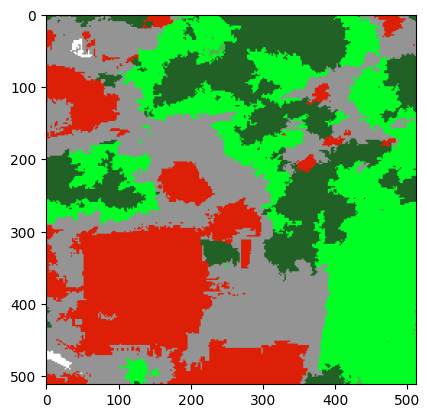

In [29]:
plt.imshow(_log['prd'])

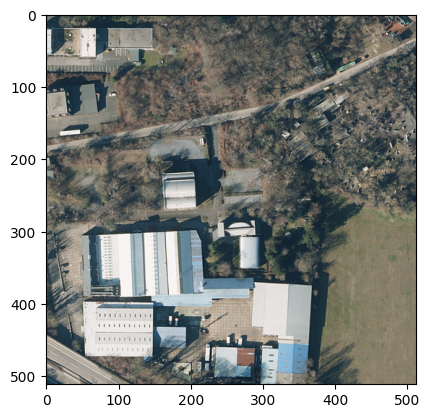

In [30]:
plt.imshow(_log['img'])

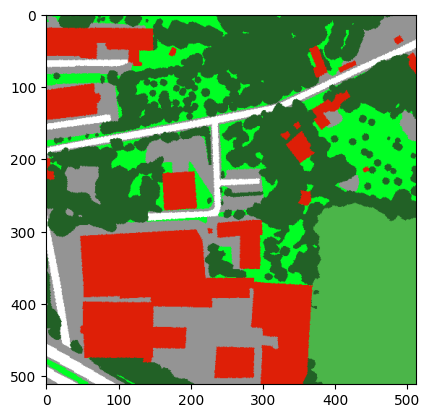

In [31]:
plt.imshow(_log['msk_discrete_rgb'])

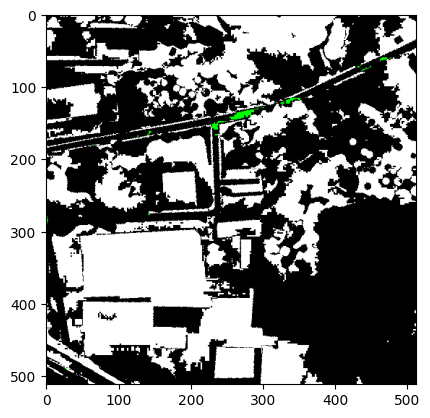

In [32]:
plt.imshow((_log['msk_discrete_rgb'] == _log['prd']).astype(np.uint8)*255)

In [33]:
model.eval().to(device)
shnet.eval().to(device)
test = True
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES, augm=None)
for idx in tqdm(range(len(test_data))):
    
    _log = joblib.load(osp.join('logs', f'_logs_test_data_{idx}.pkl'))
    
    x, edge_index, y = [_log[t] for t in ['x', 'edge_index', 'y']]
    partition_res_small, res_lst_small, msk_discrete, prd_size = [_log[t] for t in ['partition_res_small', 'res_lst_small', 'msk_discrete', 'prd_size']]
    
    data = Data(x=x, edge_index=edge_index, y=y)
    with torch.no_grad():
        out = model(data.to(device))
    out = out.detach().cpu().numpy()

    y_pred_small = np.argmax(out, axis=1)
    y_true_small = y
    y_maps_small = np.zeros(partition_res_small.shape, dtype=int)
    for i in range(y_pred_small.shape[0]):
        for t in res_lst_small[i]:
            y_maps_small[t] = y_pred_small[i]

    y_maps = cv2.resize(y_maps_small, dsize=prd_size, interpolation=cv2.INTER_NEAREST)
    prd = oem.utils.make_rgb(y_maps)
    
    miou = meanIOU(msk_discrete, y_maps)

    acc = np.sum(y_pred_small == y_true_small)/y_pred_small.shape[0]
    
    

#     _log = make_prediction(test_data, idx, model, shnet, device, preprocess,
#                        thresh=0.03, cnt_area_max=15, img_small_size=(256, 256), test=test, plot=False)
    _log['out'] = out
    _log['y_pred_small'] = y_pred_small
    _log['y_maps_small'] = y_maps_small
    _log['y_maps'] = y_maps
    _log['prd'] = prd

    _log['acc'] = acc
    _log['miou'] = miou
    
    joblib.dump(_log, osp.join('logs', f'_logs_test_data_{idx}.pkl'))    
    
    del _log


  0%|          | 0/313 [00:00<?, ?it/s]

In [34]:
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES, augm=None)
mious = []
for idx in tqdm(range(len(test_data))):
    _log = joblib.load(osp.join('logs', f'_logs_test_data_{idx}.pkl'))
    mious.append(_log['miou'])
np.mean(mious)

  0%|          | 0/313 [00:00<?, ?it/s]

0.11374062141597358

In [35]:
os.makedirs('predictions_submit', exist_ok=True)
for idx in tqdm(range(len(test_data))):
    _log = joblib.load(osp.join('logs', f'_logs_test_data_{idx}.pkl'))
    fn = _log['fn']
    final_shape = load_multiband(fn).shape[:-1]
    im = cv2.resize(_log['y_maps'].astype(np.uint8), dsize=(final_shape[1], final_shape[0]), interpolation=cv2.INTER_NEAREST)
    im = Image.fromarray(im)
    im.save(osp.join('predictions_submit',fn.split(os.sep)[-1][:-4]+'.png'))

  0%|          | 0/313 [00:00<?, ?it/s]

In [36]:
os.makedirs('predictions_rgb', exist_ok=True)
for idx in tqdm(range(len(test_data))):
    _log = joblib.load(osp.join('logs', f'_logs_test_data_{idx}.pkl'))
    fn = _log['fn']
    final_shape = load_multiband(fn).shape[:-1]
    im = cv2.resize(_log['prd'].astype(np.uint8), dsize=(final_shape[1], final_shape[0]), interpolation=cv2.INTER_NEAREST)
    im = Image.fromarray(im)
    im.save(osp.join('predictions_rgb',fn.split(os.sep)[-1][:-4]+'.png'))

  0%|          | 0/313 [00:00<?, ?it/s]

In [37]:
os.makedirs('msk_discrete_rgb', exist_ok=True)
for idx in tqdm(range(len(test_data))):
    _log = joblib.load(osp.join('logs', f'_logs_test_data_{idx}.pkl'))
    fn = _log['fn']
    final_shape = load_multiband(fn).shape[:-1]
    im = cv2.resize(_log['msk_discrete_rgb'].astype(np.uint8), dsize=(final_shape[1], final_shape[0]), interpolation=cv2.INTER_NEAREST)
    im = Image.fromarray(im)
    im.save(osp.join('msk_discrete_rgb',fn.split(os.sep)[-1][:-4]+'.png'))

  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
_log = joblib.load(osp.join('logs', f'_logs_test_data_{214}.pkl'))
fn = _log['fn']
final_shape = load_multiband(fn).shape[:-1]
im = cv2.resize(_log['y_maps'].astype(np.uint8), dsize=(final_shape[1], final_shape[0]), interpolation=cv2.INTER_NEAREST)